In [2]:
import os
model_path = "../models/random_forest_model.pkl"
print(os.path.exists(model_path))
print(os.path.getsize(model_path))


True
0


In [3]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve,
    confusion_matrix, classification_report, auc
)
import shap

# --- Load test data and trained model ---
data_path = "../data/processed/cleaned_12hr_data.csv"
data = pd.read_csv(data_path)

# --- Prepare features and target just like during training ---
target = "SepsisLabel_12hr"
drop_cols = ["SepsisLabel", "Patient_ID", target]

X = data.drop(columns=drop_cols)
y = data[target]

# --- Split data by patients to avoid leakage ---
from sklearn.model_selection import train_test_split

patients = data["Patient_ID"].unique()
train_patients, test_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=42,
    stratify=data.groupby("Patient_ID")[target].max()
)

test_df = data[data["Patient_ID"].isin(test_patients)]
X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target]


# Load saved model (adjust filename if you saved with a different name)
model_path = "../models/random_forest_model.pkl"
rf_model = joblib.load(model_path)

print("✅ Model and data loaded successfully.")


f:\Sepsis_Early_Prediction_12hr\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Model and data loaded successfully.


In [4]:
from sklearn.model_selection import train_test_split

target = "SepsisLabel_12hr"
drop_cols = ["SepsisLabel", "Patient_ID", target]

patients = data["Patient_ID"].unique()
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)

test_df = data[data["Patient_ID"].isin(test_patients)]
X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target]

print("Test data shape:", X_test.shape)


Test data shape: (310997, 63)


In [4]:
# --- Predictions ---
rf_probs = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.25
rf_preds = (rf_probs >= threshold).astype(int)

# --- Metrics ---
rf_acc = np.mean(y_test == rf_preds)
rf_f1 = classification_report(y_test, rf_preds, digits=4, output_dict=True)['1.0']['f1-score']
rf_auc = roc_auc_score(y_test, rf_probs)

print(f"Accuracy: {rf_acc:.4f}")
print(f"F1-Score (Sepsis): {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, rf_preds, digits=4))


Accuracy: 0.9157
F1-Score (Sepsis): 0.0165
AUC-ROC: 0.4568

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9864    0.9273    0.9559    306311
         1.0     0.0098    0.0531    0.0165      4146

    accuracy                         0.9157    310457
   macro avg     0.4981    0.4902    0.4862    310457
weighted avg     0.9733    0.9157    0.9434    310457



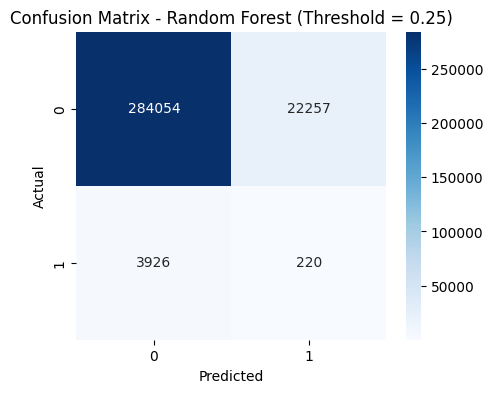

In [5]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Threshold = 0.25)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


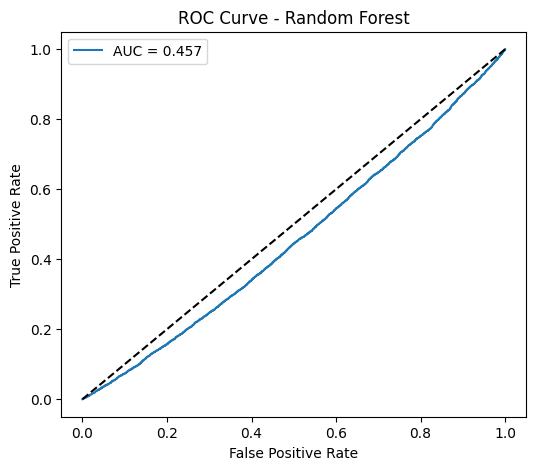

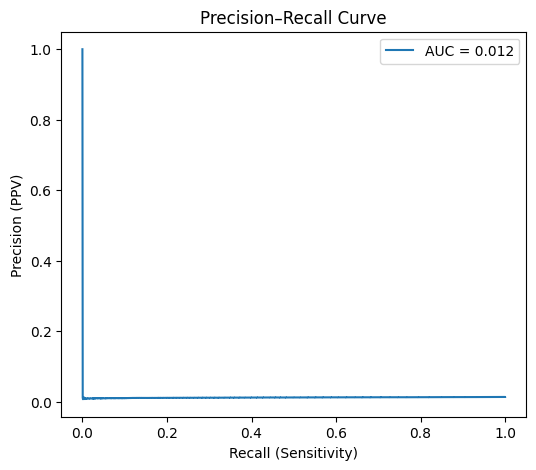

In [6]:
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rf_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, rf_probs)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


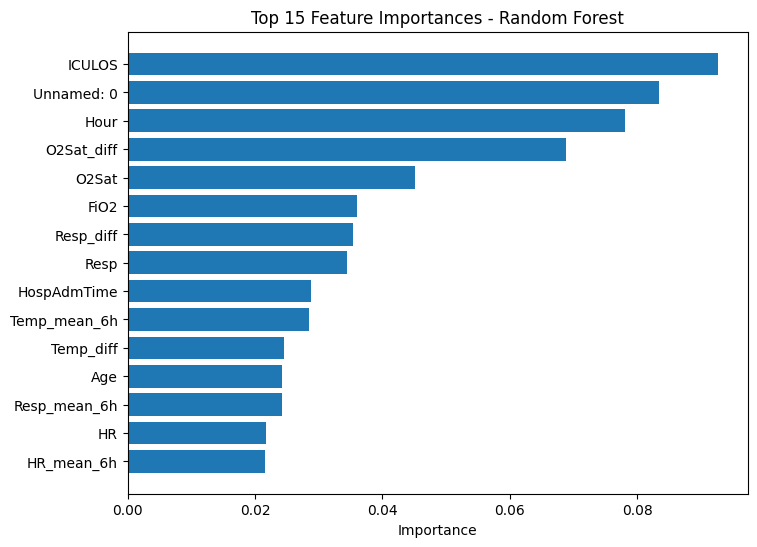

In [7]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.show()


In [8]:
import os
from sklearn.metrics import classification_report

os.makedirs("../results/reports", exist_ok=True)

# Save classification report
with open("../results/reports/final_random_forest_report.txt", "w") as f:
    f.write(classification_report(y_test, rf_preds, digits=4))

print("📁 All evaluation results saved in ../results/reports/")


📁 All evaluation results saved in ../results/reports/
